In [1]:
import _pickle as pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

/Users/lishuo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# from modelAny import *

In [3]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import embedding_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import rnn
from tensorflow.python.ops import rnn_cell
from tensorflow.python.ops import variable_scope

import gym
env = gym.make('CartPole-v0')

In [5]:
import gym
env = gym.make('Pendulum-v0')

# Setting Hyper-parameters

In [6]:
H = 8 # number of hidden layer neurons
learning_rate = 1e-2
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad**2
resume = False # resume from previous checkpoint?

model_bs = 3 # Batch size when learning from model
real_bs = 3 # Batch size when learning from real environment

# model initialization
D = 4 # input dimensionality

# Policy Network

In [7]:
tf.reset_default_graph()
observations = tf.placeholder(tf.float32, [None, 3], name='input_x')
W1 = tf.get_variable('W1', shape=[3,H],
                    initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(observations, W1))
W2 = tf.get_variable('W2', shape=[H, 1],
                    initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1, W2)
probability = tf.nn.sigmoid(score)

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32,[None,1],name='input_y')
advantages = tf.placeholder(tf.float32, name='reward_signal')
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
W1Grad = tf.placeholder(tf.float32, name='batch_grad1')
W2Grad = tf.placeholder(tf.float32, name='batch_grad2')
batchGrad = [W1Grad, W2Grad]
######################
loglik = tf.log(input_y*(input_y - probability) + (1 - input_y)*(input_y + probability))
loss = -tf.reduce_mean(loglik * advantages)
######################
newGrads = tf.gradients(loss, tvars)
updateGrads = adam.apply_gradients(zip(batchGrad, tvars))

# Model Network

Here we implement a multi-layer neural network that predicts the next observation, reward, and done state from a current state and action.

In [8]:
mH = 256 # model layer size

input_data = tf.placeholder(tf.float32, [None, 4])
with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable('softmax_w', [mH, 50])
    softmax_b = tf.get_variable('softmax_b', [50])

previous_state = tf.placeholder(tf.float32, [None, 4], name='previous_state')
W1M = tf.get_variable('W1M', shape=[4, mH], 
                     initializer=tf.contrib.layers.xavier_initializer())
B1M = tf.Variable(tf.zeros([mH]), name='B1M')
layer1M = tf.nn.relu(tf.matmul(previous_state,W1M) + B1M)
W2M = tf.get_variable('W2M', shape=[mH,mH],
                     initializer=tf.contrib.layers.xavier_initializer())
B2M = tf.Variable(tf.zeros([mH]), name='B2M')
layer2M = tf.nn.relu(tf.matmul(layer1M, W2M) + B2M)
wO = tf.get_variable('wO', shape=[mH,3],
                    initializer=tf.contrib.layers.xavier_initializer())
wR = tf.get_variable('wR', shape=[mH,1],
                    initializer=tf.contrib.layers.xavier_initializer())
wD = tf.get_variable('wD', shape=[mH,1],
                    initializer=tf.contrib.layers.xavier_initializer())
bO = tf.Variable(tf.zeros([3]), name='bO')
bR = tf.Variable(tf.zeros([1]), name='bR')
bD = tf.Variable(tf.zeros([1]), name='bD')

# output layers
predicted_observation = tf.matmul(layer2M, wO, name='predicted_observation') + bO
predicted_reward = tf.matmul(layer2M, wR, name='predicted_reward') + bR
predicted_done = tf.sigmoid(tf.matmul(layer2M, wD, name='predicted_done')+bD)

# true labels
true_observation = tf.placeholder(tf.float32,[None,3],name='true_observation')
true_reward = tf.placeholder(tf.float32,[None,1],name='true_reward')
true_done = tf.placeholder(tf.float32,[None,1],name='true_done')

predicted_state = tf.concat([predicted_observation,predicted_reward,predicted_done],1)

observation_loss = tf.square(true_observation - predicted_observation)
reward_loss = tf.square(true_reward - predicted_reward)
done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1-predicted_done, 1-true_done)
done_loss = -tf.log(done_loss)

model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)

modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate)
updateModel = modelAdam.minimize(model_loss)

# Helper-functions

In [9]:
def resetGradBuffer(gradBuffer):
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer

def discount_rewards(r):
    """
    Take 1D float array of rewards and compute discounted reward
    """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

# This function uses our model to produce a new state when given a previous state and action
def stepModel(sess, xs, action):
    toFeed = np.reshape(np.hstack([xs[-1][0], np.array(action)]), [1,4])
    myPredict = sess.run([predicted_state], feed_dict={previous_state: toFeed})
    print(myPredict)
    reward = myPredict[0][:,3]
    observation = myPredict[0][:,0:3]
#     observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
#     observation[:,2] = np.clip(observation[:,2],-2.4,0.4)
    doneP = np.clip(myPredict[0][:,4],0,1)
    if doneP > 0.1 or len(xs) >= 300:
        done = True
    else:
        done = False
    return observation, reward, done

# Training the Policy and Model NN

xs, drs, ys, ds = [], [], [], []
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.global_variables_initializer()
batch_size = real_bs

# When set to True, will use model for observations
drawFromModel = False
#Whether to train the model
trainTheModel = True
# Whether to train the policy
trainThePolicy = False
switch_point = 1

# Launch the graph
with tf.Session() as sess:
    rendering = False
    sess.run(init)
    observation = env.reset()
    x = observation
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 1000:
        # Start displaying environment once performance is acceptably high
        if (reward_sum/batch_size > 150 and drawFromModel == False) or rendering == True:
            env.render()
            rendering = True
        x = np.reshape(observation, [1,3])
        
        
        ##########################
        tfprob = sess.run(probability, feed_dict={observations: x})
        action = tfprob[0]
        # print(action)
        
        # record various intermediates (needed later for backprop)
        xs.append(x)
        y = 1 if action == 0 else 0
        ys.append(y)
        ##########################
        
        # step the model or real environment and get new measurements
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess, xs, action)
        reward_sum += reward
        
        ds.append(done*1)
        # record reward (has to be done after we call step() to get reward for previous action)
        drs.append(reward)
        
        if done:
            
            if drawFromModel == False:
                real_episodes += 1
            episode_number += 1
            
            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            xs, drs, ys, ds = [], [], [], []
            
            if trainTheModel == True:
                actions = np.array([np.abs(y-1) for y in epy][:-1])
                state_prevs = epx[:-1,:]
                #state_prevs = np.hstack([state_prevs,actions])
#                 state_prevs = np.hstack([state_prevs,actions])
                #X = np.column_stack((X, AllAlexaAndGoogleInfo))
                state_prevs = np.column_stack((state_prevs, actions))
                state_nexts = epx[1:,:]
                rewards = np.array(epr[1:,:])
                dones = np.array(epd[1:,:])
                state_nextsAll = np.hstack([state_nexts, rewards, dones])
                
                feed_dict = {previous_state:state_prevs, true_observation: state_nexts, true_done: dones, true_reward:rewards}
                #print(state_prevs)
                loss, pState, _ = sess.run([model_loss, predicted_state, updateModel], feed_dict)
                #print(pState)
                
            if trainThePolicy == True:
                discounted_epr = discount_rewards(epr).astype('float32')
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr /= np.std(discounted_epr)
                tGrad = sess.run(newGrads, feed_dict = {observations: epx, input_y: epy, advantages: discounted_epr})
                # if gradients become too large, end training process
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                for ix, grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
            
            if switch_point + batch_size == episode_number:
                switch_point = episode_number
                if trainThePolicy == True:
                    sess.run(updateGrads, feed_dict={W1Grad:gradBuffer[0], W2Grad:gradBuffer[1]})
                    gradBuffer = resetGradBuffer(gradBuffer)
                
                running_reward = reward_sum if running_reward is None else running_reward*0.99 + reward_sum*0.01
                
                if drawFromModel == False:
                    print ('World Perf: Episode %f. Reward %f. action: %f. mean reward %f.' % (real_episodes,reward_sum/real_bs,action, running_reward/real_bs))
                    if reward_sum/batch_size > 80:
                        break
                reward_sum = 0
                
                # once the model has been trained on 100 episodes, we start alternating between traing the policy from the model 
                # and training the model from the real environment
                #if episode_number > 100:
                 #   drawFromModel = not drawFromModel
                  #  trainTheModel = not trainTheModel
                   # trainThePolicy = not trainThePolicy
                    
            if drawFromModel == True:
                    # Generate reasonable starting point
                observation = np.random.uniform(-0.1,0.1,[3])
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
       # print (real_episodes)
    
    observation = env.reset()
    x = observation
    action = 0.5
    observation, reward, done = oneStepModel(sess, x, action)
    print(observation)

In [10]:
xs, drs, ys, ds = [], [], [], []
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.global_variables_initializer()
batch_size = real_bs

# When set to True, will use model for observations
drawFromModel = False
#Whether to train the model
trainTheModel = True
# Whether to train the policy
trainThePolicy = False
switch_point = 1

In [11]:
sess = tf.Session()

In [12]:
rendering = False
sess.run(init)
observation = env.reset()
x = observation
gradBuffer = sess.run(tvars)
gradBuffer = resetGradBuffer(gradBuffer)
    
while episode_number <= 1000:
    # Start displaying environment once performance is acceptably high
    if (reward_sum/batch_size > 150 and drawFromModel == False) or rendering == True:
        env.render()
        rendering = True
    x = np.reshape(observation, [1,3])
        
        
    ##########################
    tfprob = sess.run(probability, feed_dict={observations: x})
    action = tfprob[0]
    #print(action)
    # randomly pick action from [-1,1]
    action = [np.random.uniform(-2,2)]
    #print(action)
        
    # record various intermediates (needed later for backprop)
    xs.append(x)
    y = 1 if action == 0 else 0
    ys.append(y)
    ##########################
        
    # step the model or real environment and get new measurements
    if drawFromModel == False:
        observation, reward, done, info = env.step(action)
    else:
        observation, reward, done = stepModel(sess, xs, action)
        print(reward)
    reward_sum += reward
        
    ds.append(done*1)
    # record reward (has to be done after we call step() to get reward for previous action)
    drs.append(reward)
        
    if done:
            
        if drawFromModel == False:
            real_episodes += 1
        episode_number += 1
            
        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        epy = np.vstack(ys)
        epr = np.vstack(drs)
        epd = np.vstack(ds)
        xs, drs, ys, ds = [], [], [], []
            
        if trainTheModel == True:
            actions = np.array([np.abs(y-1) for y in epy][:-1])
            state_prevs = epx[:-1,:]
            #state_prevs = np.hstack([state_prevs,actions])
#               state_prevs = np.hstack([state_prevs,actions])
            #X = np.column_stack((X, AllAlexaAndGoogleInfo))
            state_prevs = np.column_stack((state_prevs, actions))
            state_nexts = epx[1:,:]
            rewards = np.array(epr[1:,:])
            dones = np.array(epd[1:,:])
            #state_nextsAll = np.hstack([state_nexts, rewards, dones])
            state_nextsAll = np.column_stack((state_nexts, rewards, dones))
                
            feed_dict = {previous_state:state_prevs, true_observation: state_nexts, true_done: dones, true_reward:rewards}
            #print(state_prevs)
            loss, pState, _ = sess.run([model_loss, predicted_state, updateModel], feed_dict)
            #print(pState)
                
        if trainThePolicy == True:
            discounted_epr = discount_rewards(epr).astype('float32')
            discounted_epr -= np.mean(discounted_epr)
            discounted_epr /= np.std(discounted_epr)
            tGrad = sess.run(newGrads, feed_dict = {observations: epx, input_y: epy, advantages: discounted_epr})
            # if gradients become too large, end training process
            if np.sum(tGrad[0] == tGrad[0]) == 0:
                break
            for ix, grad in enumerate(tGrad):
                gradBuffer[ix] += grad
            
        if switch_point + batch_size == episode_number:
            switch_point = episode_number
            if trainThePolicy == True:
                sess.run(updateGrads, feed_dict={W1Grad:gradBuffer[0], W2Grad:gradBuffer[1]})
                gradBuffer = resetGradBuffer(gradBuffer)
                
            running_reward = reward_sum if running_reward is None else running_reward*0.99 + reward_sum*0.01
                
            if drawFromModel == False:
                print ('World Perf: Episode %f. Reward %f. action: %f. mean reward %f.' % (real_episodes,reward_sum/real_bs,action[0], running_reward/real_bs))
                if reward_sum/batch_size > 80:
                    break
            reward_sum = 0
                
            # once the model has been trained on 100 episodes, we start alternating between traing the policy from the model 
            # and training the model from the real environment
            #if episode_number > 100:
                #   drawFromModel = not drawFromModel
                #  trainTheModel = not trainTheModel
                # trainThePolicy = not trainThePolicy
                    
        if drawFromModel == True:
                # Generate reasonable starting point
            observation = np.random.uniform(-0.1,0.1,[3])
            batch_size = model_bs
        else:
            observation = env.reset()
            batch_size = real_bs
       # print (real_episodes)

World Perf: Episode 4.000000. Reward -1079.306037. action: -0.462864. mean reward -1079.306037.
World Perf: Episode 7.000000. Reward -1330.779819. action: 0.014043. mean reward -1081.820775.
World Perf: Episode 10.000000. Reward -998.779927. action: -0.285962. mean reward -1080.990367.
World Perf: Episode 13.000000. Reward -1458.592889. action: 1.041904. mean reward -1084.766392.
World Perf: Episode 16.000000. Reward -1274.628990. action: -0.955545. mean reward -1086.665018.
World Perf: Episode 19.000000. Reward -1174.175513. action: -1.951115. mean reward -1087.540123.
World Perf: Episode 22.000000. Reward -1194.362314. action: 0.660882. mean reward -1088.608345.
World Perf: Episode 25.000000. Reward -1281.854916. action: 1.031394. mean reward -1090.540810.
World Perf: Episode 28.000000. Reward -1147.403319. action: -1.503202. mean reward -1091.109435.
World Perf: Episode 31.000000. Reward -1440.656952. action: -0.041663. mean reward -1094.604911.
World Perf: Episode 34.000000. Reward

World Perf: Episode 262.000000. Reward -1199.105048. action: 1.319236. mean reward -1189.310215.
World Perf: Episode 265.000000. Reward -1144.970129. action: 1.525870. mean reward -1188.866814.
World Perf: Episode 268.000000. Reward -1045.566610. action: -0.812200. mean reward -1187.433812.
World Perf: Episode 271.000000. Reward -1306.974908. action: 1.539031. mean reward -1188.629223.
World Perf: Episode 274.000000. Reward -1217.169305. action: 0.837607. mean reward -1188.914624.
World Perf: Episode 277.000000. Reward -1247.318918. action: 0.279370. mean reward -1189.498667.
World Perf: Episode 280.000000. Reward -978.560743. action: 1.235198. mean reward -1187.389288.
World Perf: Episode 283.000000. Reward -1376.086813. action: -0.931847. mean reward -1189.276263.
World Perf: Episode 286.000000. Reward -1315.790553. action: -0.181841. mean reward -1190.541406.
World Perf: Episode 289.000000. Reward -1270.168977. action: -0.592962. mean reward -1191.337681.
World Perf: Episode 292.000

World Perf: Episode 520.000000. Reward -1384.031128. action: 1.421591. mean reward -1210.498212.
World Perf: Episode 523.000000. Reward -1262.220698. action: 1.884854. mean reward -1211.015436.
World Perf: Episode 526.000000. Reward -1323.234503. action: 0.076852. mean reward -1212.137627.
World Perf: Episode 529.000000. Reward -1182.673407. action: 1.995636. mean reward -1211.842985.
World Perf: Episode 532.000000. Reward -1378.363280. action: 0.318126. mean reward -1213.508188.
World Perf: Episode 535.000000. Reward -1365.086410. action: 1.422117. mean reward -1215.023970.
World Perf: Episode 538.000000. Reward -1405.701605. action: -0.418644. mean reward -1216.930746.
World Perf: Episode 541.000000. Reward -1113.512912. action: 1.551447. mean reward -1215.896568.
World Perf: Episode 544.000000. Reward -1513.419842. action: 1.149854. mean reward -1218.871801.
World Perf: Episode 547.000000. Reward -1255.021099. action: -1.311610. mean reward -1219.233294.
World Perf: Episode 550.0000

World Perf: Episode 778.000000. Reward -1526.561729. action: -0.965611. mean reward -1218.959692.
World Perf: Episode 781.000000. Reward -1433.498693. action: 1.406658. mean reward -1221.105082.
World Perf: Episode 784.000000. Reward -1220.831452. action: 0.044863. mean reward -1221.102346.
World Perf: Episode 787.000000. Reward -1241.540420. action: -0.643120. mean reward -1221.306727.
World Perf: Episode 790.000000. Reward -1037.271652. action: 1.815450. mean reward -1219.466376.
World Perf: Episode 793.000000. Reward -1336.031522. action: -0.587111. mean reward -1220.632028.
World Perf: Episode 796.000000. Reward -1200.741119. action: -0.988221. mean reward -1220.433118.
World Perf: Episode 799.000000. Reward -1199.111856. action: 1.036486. mean reward -1220.219906.
World Perf: Episode 802.000000. Reward -1437.781556. action: -0.404922. mean reward -1222.395522.
World Perf: Episode 805.000000. Reward -1080.846307. action: -1.321365. mean reward -1220.980030.
World Perf: Episode 808.

In [16]:
# This function uses our model to produce a new state when given a previous state and action
def oneStepModel(sess, x, action):
    toFeed = np.reshape(np.append(x, [action]),[1,4])
    myPredict = sess.run([predicted_state], feed_dict={previous_state: toFeed})
    reward = myPredict[0][:,3]
    observation = myPredict[0][:,0:3]
    observation[:,:2] = np.clip(observation[:,:2],-1,1)
    doneP = np.clip(myPredict[0][:,4],0,1)
    if doneP > 0.1 or len(xs) >= 300:
        done = True
    else:
        done = False
    return observation, reward, done

In [14]:
observation = env.reset()
x = observation
action = 0.5
observation, reward, done = oneStepModel(sess, x, action)
print(observation)

[[-0.61172545  0.7935567   1.56822   ]]


In [15]:
observation = env.step([0])
print(observation)

(array([-0.6114943 ,  0.79124883,  1.53522494]), -4.713543012997036, False, {})


# Checking model representation

Here we can examine how well the model is ablt to approximate the true environment after training. The green line indicates the real environment, and the blue indicates model predications.

/Users/lishuo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


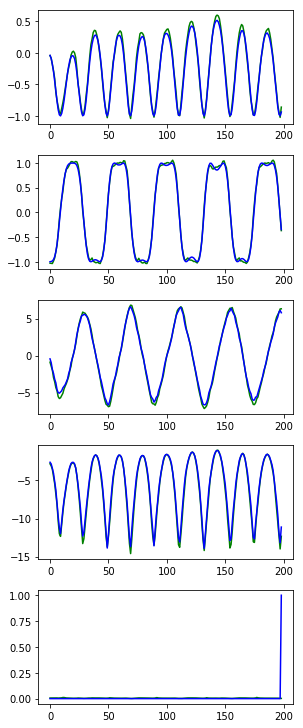

In [17]:
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:,i],'g')
    plt.subplot(6,2,2*i+1)
    plt.plot(state_nextsAll[:,i],'b')
plt.tight_layout()

# Discrete state and input space

In [18]:
def binning(data, bins):
    inds = np.digitize(data, bins)
    return bins[inds-1]

In [19]:
bins_state = np.linspace(-1, 1, 9)
bins_dtheta_dt = np.linspace(-8, 8, 12)
bins_action = np.linspace(-2,2,30)
bins_theta = np.linspace(-np.pi,np.pi,9)

In [20]:
class Node():
    """
    A node calss for A* Pathfinding
    """
    
    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position
        
        self.g = 0
        self.h = 0
        self.h = 0
    
    def __eq__(self, other):
        return self.position == other.position

# step 1: start from a random init state s0;
s0 = env.reset()
 
theta = np.arctan2(s0[0], s0[1])
theta = binning(theta, bins_theta)
s0[-1] = binning(s0[-1],bins_dtheta_dt)

v_next = []
v_reward = []
v_done = []
# step 2: take all possible actions and store all possible next state.
for action in bins_action:
    observation, reward, done = oneStepModel(sess, s0, action)
    v_next.append(observation)
    v_reward.append(reward)
    v_done.append(done)

In [21]:
def f_cost(reward, action):
    return reward
#     return reward - action**2

In [22]:
# step 1: start from a random init state s0;
s0 = env.reset()
print('<><><><><>')
print(s0)

v_next = [s0] * 8
v_reward = [-float('inf')] * 8
v_done = [False]*8

current_state = s0
route = [s0.tolist()]
print(route)
while (current_state[0] > 0.1) or (current_state[0] < -0.1):
    theta = np.arctan2(current_state[0], current_state[1])
    theta = binning(theta, bins_theta)
    current_state[0] = np.sin(theta)
    current_state[1] = np.cos(theta)
    current_state[2] = binning(current_state[-1],bins_dtheta_dt)
    
    # step 2: take all possible actions and store all possible next state.
    v_next = [current_state] * 8
    v_reward = [-float('inf')] * 8
    v_done = [False]*8
    for action in bins_action:
        observation, reward, done = oneStepModel(sess, current_state, action)
        v_next.append(observation)
        v_reward.append(reward)
        v_done.append(done)
    
    v_cost = []
    for index, action in enumerate(bins_action):
        print('*************')
        print((v_reward[index], action))
        v_cost.append(f_cost(v_reward[index], action))
    index_min = np.argmax(v_cost)
    current_state = v_next[index_min][0]
    print("------------")
    print(current_state)
    print(route)
    route.append(current_state.tolist())
    print(route)
    next_cost = v_cost[index_min] 

print(route)

<><><><><>
[-0.12672007  0.99193852  0.2318939 ]
[[-0.1267200708068343, 0.9919385180819983, 0.2318939039170751]]
*************
(-inf, -2.0)
*************
(-inf, -1.8620689655172413)
*************
(-inf, -1.7241379310344827)
*************
(-inf, -1.5862068965517242)
*************
(-inf, -1.4482758620689655)
*************
(-inf, -1.3103448275862069)
*************
(-inf, -1.1724137931034484)
*************
(-inf, -1.0344827586206897)
*************
(array([-3.414098], dtype=float32), -0.896551724137931)
*************
(array([-3.4312732], dtype=float32), -0.7586206896551724)
*************
(array([-3.4771557], dtype=float32), -0.6206896551724137)
*************
(array([-3.5299065], dtype=float32), -0.48275862068965525)
*************
(array([-3.5991075], dtype=float32), -0.3448275862068966)
*************
(array([-3.6865253], dtype=float32), -0.2068965517241379)
*************
(array([-3.7747416], dtype=float32), -0.06896551724137945)
*************
(array([-3.8703203], dtype=float32), 0.068965517

In [23]:
route

[[-0.1267200708068343, 0.9919385180819983, 0.2318939039170751],
 [-0.719737708568573, 0.24693897366523743, 0.9978458881378174],
 [-0.7963481545448303, -0.20402947068214417, 1.725785732269287],
 [-0.49498942494392395, -0.5082142949104309, 0.5275678038597107],
 [0.08157039433717728, -0.8803534507751465, -1.5820339918136597]]

In [ ]:
def astar(maze, start, end):
    """
    Returns a list of tuples as a path from the given start to the given end in the given maze.
    """
    
    # Create start and end node
    start_node = Node(None, start)
    start_node.g = start_node.h = start_node.f = 0
    end_node = Node(None, end)
    end_node.g = end_node.h = end_node.f = 0
    
    # Initialize both open and closed list
    open_list = []
    closed_list = []
    
    # Add the start node
    open_list.append(start_node)
    
    # Loop until you find the end
    while len(open_list) > 0:
        
        # Get the current node
        current_node = open_list[0]
        current_index = 0
        for index, item in enumerate(open_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index
        
        # Pop current off open list, add to closed list
        open_list.pop(current_index)
        closed_list.append(current_node)
        
        # Found the goal
        if current_node == end_node:
            path = []
            current = current_node
            while current is not None:
                path.append(current.position)
                current = current.parent
            return path[::-1]
        
        # Generate children
        children = []
        
        ###########
        # step 1: get current state
        # step 2: input all possible input signal into model neural network
        # step 3: get all possible children points
        ###########
        
        for new_position in [(0,-1),(0,1),(-1,0),(1,0),(-1,-1),(-1,1),(1,-1),(1,1)]: # Adjacent squares
            
            # Get node position
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])
            
            # Make sure within range
            if node_position[0] > (len(maze)-1) or node_position[0] < 0 or node_position[1] > (len(maze[len(maze)-1])-1) or node_position[1]<0:
                continue
            
            # Make sure walkable terrain
            if maze[node_position[0]][node_position[1]] != 0:
                continue
            
            # Create new node
            new_node = Node(current_node, node_position)
            
            # Append
            children.append(new_node)
        
        # Loop through children
        for child in children:
            
            # Child is on the closed list
            for closed_child in closed_list:
                if child == closed_child:
                    continue
            
            # Create the f, g, and h values
            child.g = current_node.g + 1
            child.h = ((child.position[0] - end_node.position[0])**2) + ((child.position[1] - end_node.position[1])**2)
            child.f = child.g + child.h
            
            # Child is already in the open list
            for open_node in open_list:
                if child == open_node and child.g > open_node.g:
                    continue
            
            # Add the child to the open list
            open_list.append(child)

In [ ]:
maze = [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
start = (0,0)
end = (7,6)

path = astar(maze, start, end)
print(path)